# Exercise 3 - Binary Classification with Logistic Regression

This exercise is meant to familiarize you with the complete pipeline of solving a machine learning problem. You
need to obtain and pre-process the data, develop, implement and train a machine learning model and evaluate it
by splitting the data into a train and testset.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de

### Submission
- Deadline of submission:
        03.05.23 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=43681)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

## Data Preparation

In the model of **logistic regression**, we have $m$ samples $x_i\in\mathbb{R}^n$ with labels $y_i\in\{-1,1\}$.

In this exercise, we will use the equivalent formulation with $y_i\in\{0,1\}$.
We use the example dataset `data.npy`, where we have 2 dimensional features (first two columns) and a binary label (3rd column).

### Task 1
Load and split the dataset into samples and labels. Then plot the data with a scatterplot and use different colors for different labels.

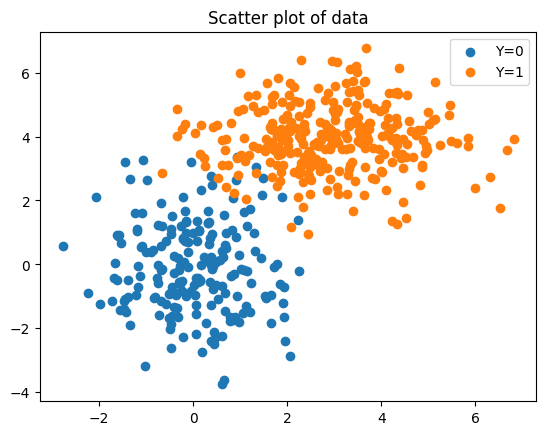

In [148]:
# TODO: Load and split dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set seed for reproducibility


data = np.load("data.npy")


pd.DataFrame(data)

X = data[:, 0:2]
Y = data[:, 2]

assert data[2,1] == X[2,1]

class0 = np.where(Y == 0)
class1 = np.where(Y == 1)

X0 = X[class0]
X1 = X[class1]

plt.title("Scatter plot of data")
plt.scatter(X0[:, 0], X0[:, 1], label="Y=0")
plt.scatter(X1[:, 0], X1[:, 1], label="Y=1")
plt.legend()
plt.show()

## Model



The function $\sigma$ is called the logistic *sigmoid function*:

\begin{align}
\sigma(a) = \cfrac{1}{1+\exp(-a)}\ .
\end{align}


###  Task 2
Implement a vectorized logistic sigmoid function, i.e. it takes a vector of x-coordinates X and returns a vector of their respective y values. Use it to plot the function between -10 and 10.

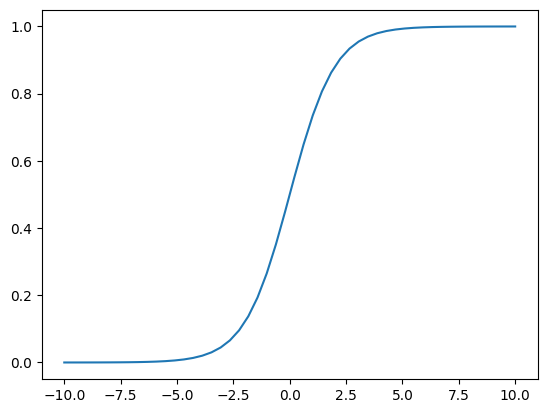

In [149]:
def sigmoid(X : np.ndarray) -> np.ndarray:
    '''
    Sigmoid function.
    
    @Params:
        X... array of x
        
    @Returns:
        array of sigmoid(x)
    '''
    # implement
    return 1 / (1 + np.exp(-1 * X))


# Plot function from -10 to 10
import matplotlib.pyplot as plt

_x = np.linspace(-10, 10)
_prediction = sigmoid(_x)

plt.plot(_x, _prediction)

plt.show()

The goal in logistic regression is to find the parameter vector $\theta\in\mathbb{R}^n$, so that 

\begin{align}
p(y_i=1|x_i,\theta)&=\sigma(x_i^T\theta)\\
p(y_i=0|x_i,\theta)&=1-p(y_i=1|x_i,\theta)
\end{align}

fits our data and can be used to predict the label on unseen data (binary classification).


With an estimated $\theta$, a new feature $x\in\mathbb{R}^n$ is classified according to:

\begin{align}
\hat{y} = \begin{cases}
1&\text{, if }p(y=1|x,\theta)\geq 0.5\\
0&\text{, else}
\end{cases}.
\end{align}

Since $\sigma(0) =  1/(1+\exp(0)) = 0.5$. This is equivalent to 
\begin{align}
\hat{y} = \begin{cases}
1&\text{, if } x_i^T\theta \geq 0\\
0&\text{, else}
\end{cases}
\end{align}
 as noted in the lecture.

### Task 3
Prepare `X` so that the classification function for an estimated $\theta$ is [*affine*](https://math.stackexchange.com/questions/275310/what-is-the-difference-between-linear-and-affine-function). Add this affine component at the **first column**.

In [150]:
# TODO: Prepare X
X_affine = np.column_stack([np.ones(len(X)), X])
X_affine

array([[ 1.        ,  4.8777683 ,  3.89871851],
       [ 1.        , -1.1680935 , -0.05555429],
       [ 1.        , -0.68944918,  1.92973945],
       ...,
       [ 1.        , -1.7262826 , -1.1499625 ],
       [ 1.        , -1.18388064,  1.09354485],
       [ 1.        ,  3.33208779,  6.13215341]])

### Task 4

Implement a `predict` function based on the above definition of probabilities.

Test your function with a randomly chosen $\theta$.

In [151]:
def predict(X : np.ndarray, theta: np.ndarray) -> np.ndarray:
    '''
    Predicts Y given X and theta.
    
    @Params:
        X... matrix with datapoints as rows (m x n)
        theta... parameter vector (n)
        
    @Returns:
        array of predictions (m)
    '''
    # implement
    return np.where(X @ theta >= 0, 1, 0)

# test function
np.random.seed(0)

_prediction = predict(
    X_affine,
    np.random.rand(X_affine.shape[1])
)

_error_w_random_theta = np.count_nonzero(_prediction - Y) / Y.shape[0]

"Error:", _error_w_random_theta, "Accuracy:", 1 - _error_w_random_theta # wtf, q.e.d


('Error:', 0.27, 'Accuracy:', 0.73)

## Learning $\theta$

For a given $\theta$, we can calculate $p(y|x,\theta)$ and use this probability for classification.
To evaluate how well a learned $\theta$ can be used to classify our data, we define a *loss function*.
Here we want to use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) given as:

\begin{align}
L(\theta) = -\cfrac{1}{m}\sum_{i=1}^m y_i\log(p(y_i=1|x_i,\theta))+(1-y_i)\log(1-p(y_i=1|x_i,\theta))
\end{align}

Often it is convenient to have multiple metrics at hand. In classification problems, the *accuracy* of a
prediction is defined as the percentage of correctly classified features. In the case of logistic regression, this corresponds to 

\begin{align}
Acc(\theta) = \cfrac{1}{m}\sum_{i=1}^m y_i \hat{y_i} + (1-y_i)(1-\hat{y_i})
\end{align}
where $\hat{y_i}$ is the prediction for $x_i$.

As our model becomes better, we expect the accuracy to increase and the loss to decrease.  

### Task 5
Implement the binary cross entropy and the accuracy for logistic regression. 

Again, test your functions with a randomly chosen $\theta$.

In [152]:
def cross_entropy_loss(X : np.ndarray, Y : np.ndarray, theta : np.ndarray) -> float:
    '''
    Binary cross entropy loss.
    
    @Params:
        X... matrix with datapoints as rows (m x n)
        Y... array of true labels (n)
        theta... parameter vector (n)
        
    @Returns:
        binary cross entropy
    '''
    # implement

    p = sigmoid(X @ theta)
    return -1 * np.mean(Y * np.log(p) + (1-Y) * np.log(1-p))

def acc(X : np.ndarray, Y : np.ndarray, theta : np.ndarray) -> float:
    '''
    Accuracy.
    
    @Params:
        X... matrix with datapoints as rows (m x n)
        Y... array of true labels (n)
        theta... parameter vector (n)
        
    @Returns:
        binary cross entropy
    '''
    
    # implement
    labels = Y.flatten()
    predictions = predict(X, theta).flatten()

    return np.mean(list(map(lambda x_i, y_i: x_i*y_i + (1 - x_i)*(1 - y_i), labels, predictions))).__float__()

# test function
np.random.seed(0)

_cross_entropy_loss = cross_entropy_loss(
    X_affine,
    Y,
    np.random.rand(X_affine.shape[1])
)

np.random.seed(0)

_accuracy = acc(
    X_affine,
    Y,
    np.random.rand(X_affine.shape[1])
)

'Acc different way', _accuracy, 'cross entropy loss', _cross_entropy_loss

('Acc different way', 0.73, 'cross entropy loss', 0.44557368213985954)

Given the loss function $L(\theta)$, we want to minimize this function with respect to the parameters $\theta$, that is we are looking for

\begin{align}
    \text{argmin}_\theta L(\theta)
\end{align}

However, since this is a highly nonlinear optimization problem, we use an iterative approach that starts with an initial estimate for $\theta$ and approaches the solution at each iteration step. 
The most simple approach is to take the gradient
$\nabla L(\theta)$ of $L(\theta)$ with respect to $\theta$ and walk into direction of the negative gradient. 
This method is called gradient-descent.

### Task 6

Find out $\nabla L(\theta) = \cfrac{d L}{d \theta}$ and implement this function.
The resulting function takes features $X$, labels $Y$ and $\theta$ as input and outputs a gradient $\nabla L(\theta)\in\mathbb{R}^n$.

Again, test your function with a randomly chosen $\theta$.

Solution:
\begin{align}
\cfrac{\partial L}{\partial \theta} =\cfrac{1}{m}\sum_{i=1}^m x_i (\sigma(x_i^T\theta)-y_i)
\end{align}

In [153]:
def cross_entropy_gradient(X : np.ndarray, Y : np.ndarray, theta : np.ndarray):
    '''
    Gradient of binary crossentropy. wrt theta.
    
    @Params:
        X... matrix with datapoints as rows (m x n)
        Y... array of true labels (n)
        theta... parameter vector (n)
        
    @Returns:
        gradient at point theta
    '''
    # implement
    return 1/X.shape[0] * (X.T @ (sigmoid(X @ theta) - Y))

# test function
np.random.seed(0)


_theta_iter = np.random.rand(X_affine.shape[1])

for i in range(10):
    _cross_entropy_gradient = cross_entropy_gradient(
        X_affine,
        Y,
        _theta_iter
    )
    _theta_iter = _theta_iter - (0.01 * _cross_entropy_gradient)


'ex. cross entropy gradient', _cross_entropy_gradient

('ex. cross entropy gradient', array([0.22947759, 0.04139717, 0.03846827]))

### Task 7
Implement the fit function for the following Logistic Regression class:

 1. (randomly) choose initial $\hat{\theta}$
 2. update $\hat{\theta} \leftarrow \hat{\theta} -\eta\nabla L(\hat{\theta})$
 3. repeat 2. until a maximum number of iterations $\lambda$ (parameter `max_it`) is reached or the loss did not change more than $\varepsilon$ (parameter `eps`).
 
The hyperparameter $\eta$ is also called *learning rate* (parameter `lr`).

Additionaly track the losses and accuracies that occur during the iterations of gradient descend. 

Test your class (on the prepared data from above) and plot the accuracies and losses over the iterations.

X affine (500, 3) Y shape (500,)
theta (3,)
Iter 0, Accuracy: 0.734
Iter 100, Accuracy: 0.974
Iter 200, Accuracy: 0.98
Iter 300, Accuracy: 0.974
Iter 400, Accuracy: 0.97
Iter 500, Accuracy: 0.97
Iter 600, Accuracy: 0.97
Iter 700, Accuracy: 0.97
Iter 800, Accuracy: 0.97
Iter 900, Accuracy: 0.97

Accuracy start: 0.734 
Accuracy finish: 0.97
Finished due to max_it reached


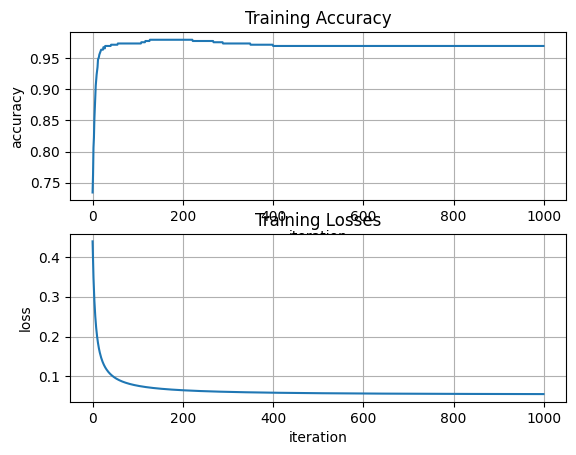

In [154]:
class LogReg():
    def __init__(self):
        '''
        Class for Logistic regression.
        '''
        self.theta = None # parameter vector
        self.accs = [] # accuracies
        self.losses = [] # losses


    def predict(self, X : np.ndarray) -> np.ndarray:
        '''
        Predicts Y given X and learned theta.

        @Params:
            X... matrix with datapoints as rows (m x n)

        @Returns:
            array of predictions (m)
        '''
        return predict(X, self.theta)
    
    
    def fit(self, X : np.ndarray, Y : np.ndarray, lr : float = 1e-2, max_it : int = 1000, eps : float = 1e-5) -> None:
        '''
        Gradient descend for binary crossentropy.

        @Params:
            X... matrix with datapoints as rows (m x n)
            Y... array of true labels (n)
            lr... learnrate, sets stepsize for descend
            max_it... maximum number of steps
            eps... abort criterium for early stopping (loss did not change more than this)

        '''

        self.theta = np.random.rand(X.shape[1])
        print("theta", self.theta.shape)

        for i in range(max_it):
            loss = cross_entropy_loss(X, Y, self.theta)
            accuracy = acc(X, Y, self.theta)

            self.losses.append(loss)
            self.accs.append(accuracy)

            ceg = cross_entropy_gradient(X, Y, self.theta)

            if i % 100 == 0:
                print(f"Iter {i}, Accuracy: {accuracy}")

            if loss < eps:
                break

            self.theta -= ceg

        print("\nAccuracy start:", self.accs[0], "\nAccuracy finish:", self.accs[-1])
        print("Finished due to", "max_it reached" if i == max_it-1 else "change smaller than epsilon")
        pass
                
# TODO: test class + plot losses/accuracies
logreg = LogReg()

print("X affine", X_affine.shape, "Y shape", Y.shape)

logreg.fit(X_affine, Y)

fig, ax = plt.subplots(2)
ax[0].plot(logreg.accs)
ax[0].set_title("Training Accuracy")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("accuracy")
ax[0].grid()

ax[1].plot(logreg.losses)
ax[1].set_title("Training Losses")
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("loss")
ax[1].grid()

plt.show()

### Task 8

So far, we used the whole dataset for fitting the `LogReg` class.

- Use [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into train (75%) and testset (25%).
- Fit the Logistic Regression model on the trainset and calculate the final accuracies on the train and testset. 
- Experiment with the hyperparameters for fit, to get a good result.

theta (3,)
Iter 0, Accuracy: 0.76
Iter 100, Accuracy: 0.9786666666666667
Iter 200, Accuracy: 0.976
Iter 300, Accuracy: 0.9706666666666667
Iter 400, Accuracy: 0.9706666666666667
Iter 500, Accuracy: 0.9706666666666667
Iter 600, Accuracy: 0.9706666666666667
Iter 700, Accuracy: 0.9706666666666667
Iter 800, Accuracy: 0.9706666666666667
Iter 900, Accuracy: 0.9706666666666667

Accuracy start: 0.76 
Accuracy finish: 0.9706666666666667
Finished due to max_it reached
Accuracy on training data: 0.9706666666666667
Accuracy on test data: 0.976
theta (3,)
Iter 0, Accuracy: 0.744

Accuracy start: 0.744 
Accuracy finish: 0.9786666666666667
Finished due to max_it reached
theta (3,)
Iter 0, Accuracy: 0.6853333333333333

Accuracy start: 0.6853333333333333 
Accuracy finish: 0.936
Finished due to change smaller than epsilon
theta (3,)
Iter 0, Accuracy: 0.7946666666666666

Accuracy start: 0.7946666666666666 
Accuracy finish: 0.9786666666666667
Finished due to max_it reached
theta (3,)
Iter 0, Accuracy: 0.72

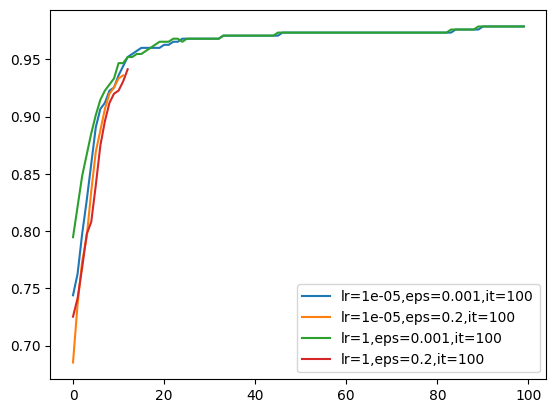

In [155]:
# TODO: Split data into train and test data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

train_data, test_data = train_test_split(data, shuffle=False)
X_train = train_data[:,0:2]
Y_train = train_data[:,2]
X_test = test_data[:,0:2]
Y_test = test_data[:,2]

X_train_affine = np.column_stack([np.ones(len(X_train)), X_train])
X_test_affine = np.column_stack([np.ones(len(X_test)), X_test])

# TODO: apply logistic regression
# Werte wie oben
lr = 1e-2
eps = 1e-5
max_it = 1000

logreg2 = LogReg()
logreg2.fit(X_train_affine, Y_train, lr, max_it, eps)

# TODO: determine train and test accuracy
print(f"Accuracy on training data: {logreg2.accs[-1]}")
print(f"Accuracy on test data: {acc(X_test_affine, Y_test, logreg2.theta)}")

lr_params = [0.00001, 1]
eps_params = [0.001, 2e-1]

fig, ax = plt.subplots()
max_it_params = [100]

for _lr in lr_params:
    for _eps in eps_params:
        for _max_it in max_it_params:
            _logreg = LogReg()
            _logreg.fit(X_train_affine, Y_train, _lr, _max_it, _eps)
            ax.plot(np.arange(len(_logreg.accs)), _logreg.accs, label=f"lr={_lr},eps={_eps},it={_max_it}")

ax.legend()
plt.show()

## Visualization

Next we want to visualize our classifier. To to this, we want to visualize the *decision boundary* defined by $\hat{\theta}$.

The decision boundary is defined as 
$
\{x\in\mathbb{R}^n: p(y=1|x)=0.5\}
$
or as in the lecture:
$\{x\in \{1\} \times \mathbb{R}^n: x^T\hat{\theta}=0\}$


### Task 9

Implement a function `plot_dec_boundary` that visualizes the data and the regression line for 2 dimensional samples $X$ and an estimated $\hat{\theta}$.

Test this function with the $\hat{\theta}$ estimated in Task 8.

theta (3,)
Iter 0, Accuracy: 0.704
Iter 100, Accuracy: 0.9786666666666667
Iter 200, Accuracy: 0.976
Iter 300, Accuracy: 0.9706666666666667
Iter 400, Accuracy: 0.9706666666666667
Iter 500, Accuracy: 0.9706666666666667
Iter 600, Accuracy: 0.9706666666666667
Iter 700, Accuracy: 0.9706666666666667
Iter 800, Accuracy: 0.9706666666666667
Iter 900, Accuracy: 0.9706666666666667

Accuracy start: 0.734 
Accuracy finish: 0.9706666666666667
Finished due to max_it reached


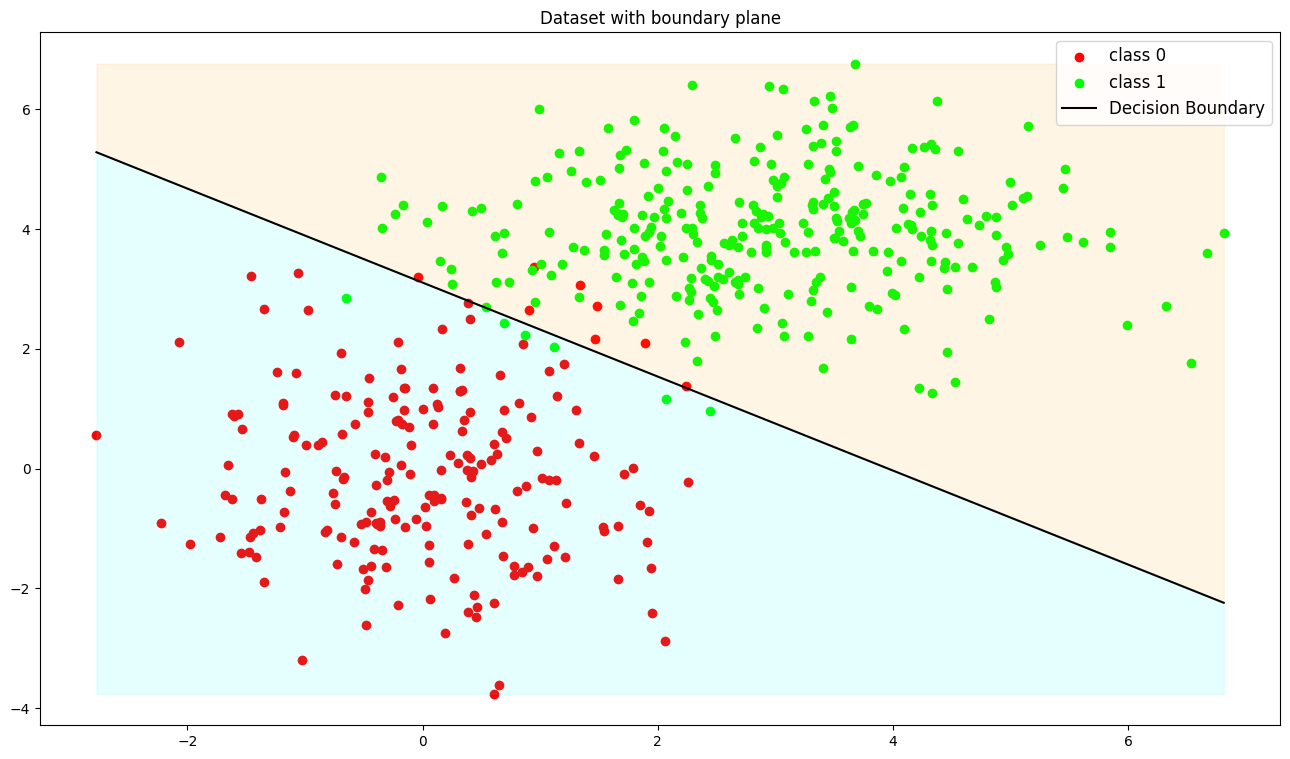

In [156]:
def plot_dec_boundary(X : np.ndarray, Y : np.ndarray, theta : np.ndarray, bias : float = None):
    '''
    Plots the decision boundary for 2D logistic regression task.
    
    @Params:
        X... matrix with datapoints as rows (m x 2)
        Y... array of true labels (m)
        theta... parameter vector (2)
    '''
    
    # plot data and decision boundary
    class_0 = np.where(Y == 0)
    class_1 = np.where(Y == 1)

    X_0 = X[class_0[0]]
    X_1 = X[class_1[0]]

    x_min = min(X.T[0])
    x_max = max(X.T[0])

    y_min = min(X.T[1])
    y_max = max(X.T[1])

    x_boundary = np.linspace(x_min, x_max, 10)

    if bias:
        y_boundary = ((- theta[1] * x_boundary) -  bias) / theta[2]
    else:
        y_boundary = (-1*theta[0] - x_boundary * theta[1]) / theta[2]

    # print("y boundary", y_boundary.shape)
    # print("x boundary", x_boundary.shape)

    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_title("Dataset with boundary plane")
    ax.scatter(X_0[:, 0], X_0[:, 1], color="red", label="class 0")
    ax.scatter(X_1[:, 0], X_1[:, 1], color="lime", label="class 1")
    ax.plot(x_boundary, y_boundary, color="black", label="Decision Boundary")
    ax.legend(fontsize=12)

    plt.fill_between(x_boundary, y_boundary, y_min, color="cyan", alpha=0.1)
    plt.fill_between(x_boundary, y_boundary, y_max, color="orange", alpha=0.1)

    plt.show()
    pass
    
# TODO: test function
logreg.fit(X_train_affine, Y_train)
plot_dec_boundary(X, Y, logreg.theta)

### Task 10

Use the [implementation from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to train a logistic regressor.

Visualize the regression line that you obtain with scikit learn.

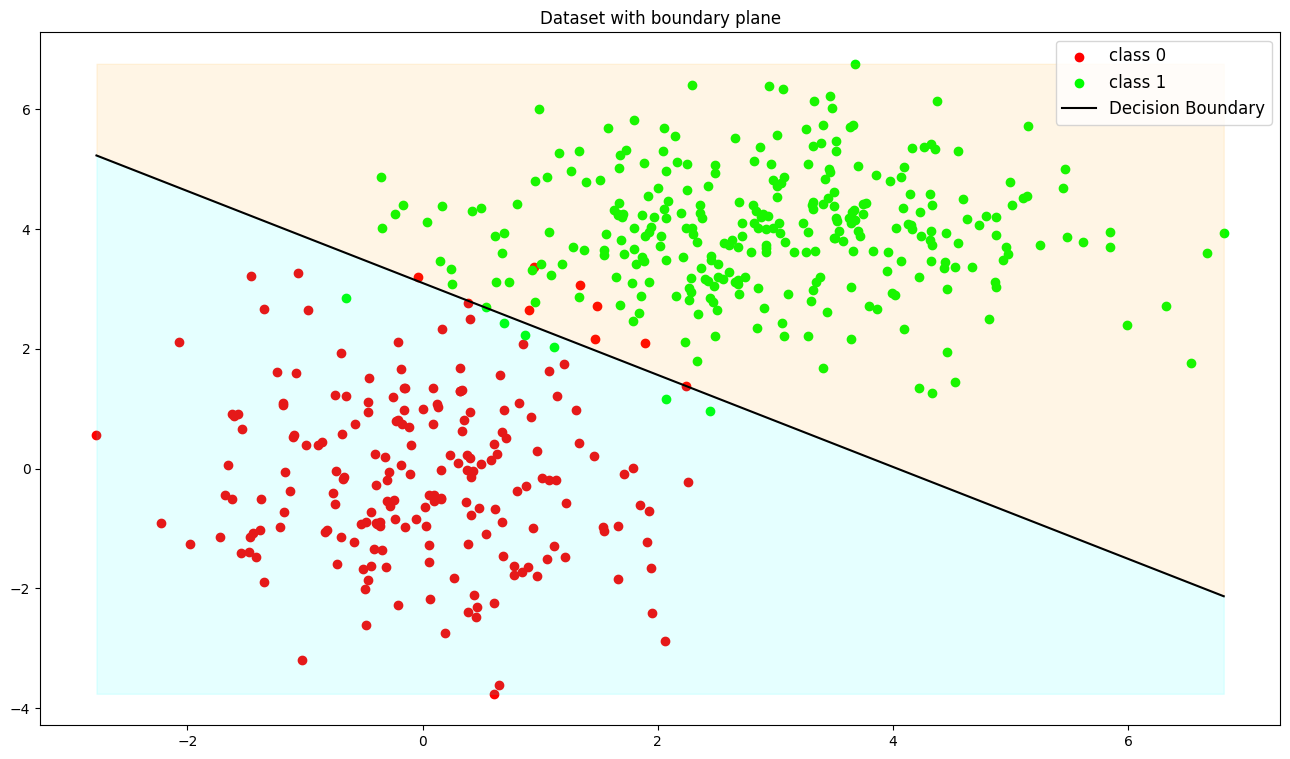

In [157]:
# TODO: estimate theta with scikit-learn
clf = LogisticRegression(random_state=0).fit(X_train_affine, Y_train)

# TODO: plot regression line with data

bias = clf.intercept_[0]
theta = clf.coef_.flatten()

plot_dec_boundary(X, Y, theta, bias)